# Unsupervised clustering exercise

## Contents

* [1. Data preparation](#prep)
    * [1.1. Overview](#over)
    * [1.2 PCA](#pca)
* [2. Model Construction](#cons)
    * [2.1. K means](#ks)
        * [2.1.1 Determine k](#dk)
        * [2.1.2 Dendrogram](#dg)
        * [2.1.3 Fit K means](#fk)
    * [2.2 DBSCAN](#df)
* [Results](#res)
    

## 1. Data preparation<a id="prep"></a>
### 1.1 Overview<a id="over"></a>

In [1]:
# packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import warnings
from sklearn.datasets import load_iris

warnings.filterwarnings('ignore') # turn off warnings

In [4]:
# load data
data = load_iris()

# ignore target to make it an unlabeled dataset
df = pd.DataFrame(data.data, columns=data.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


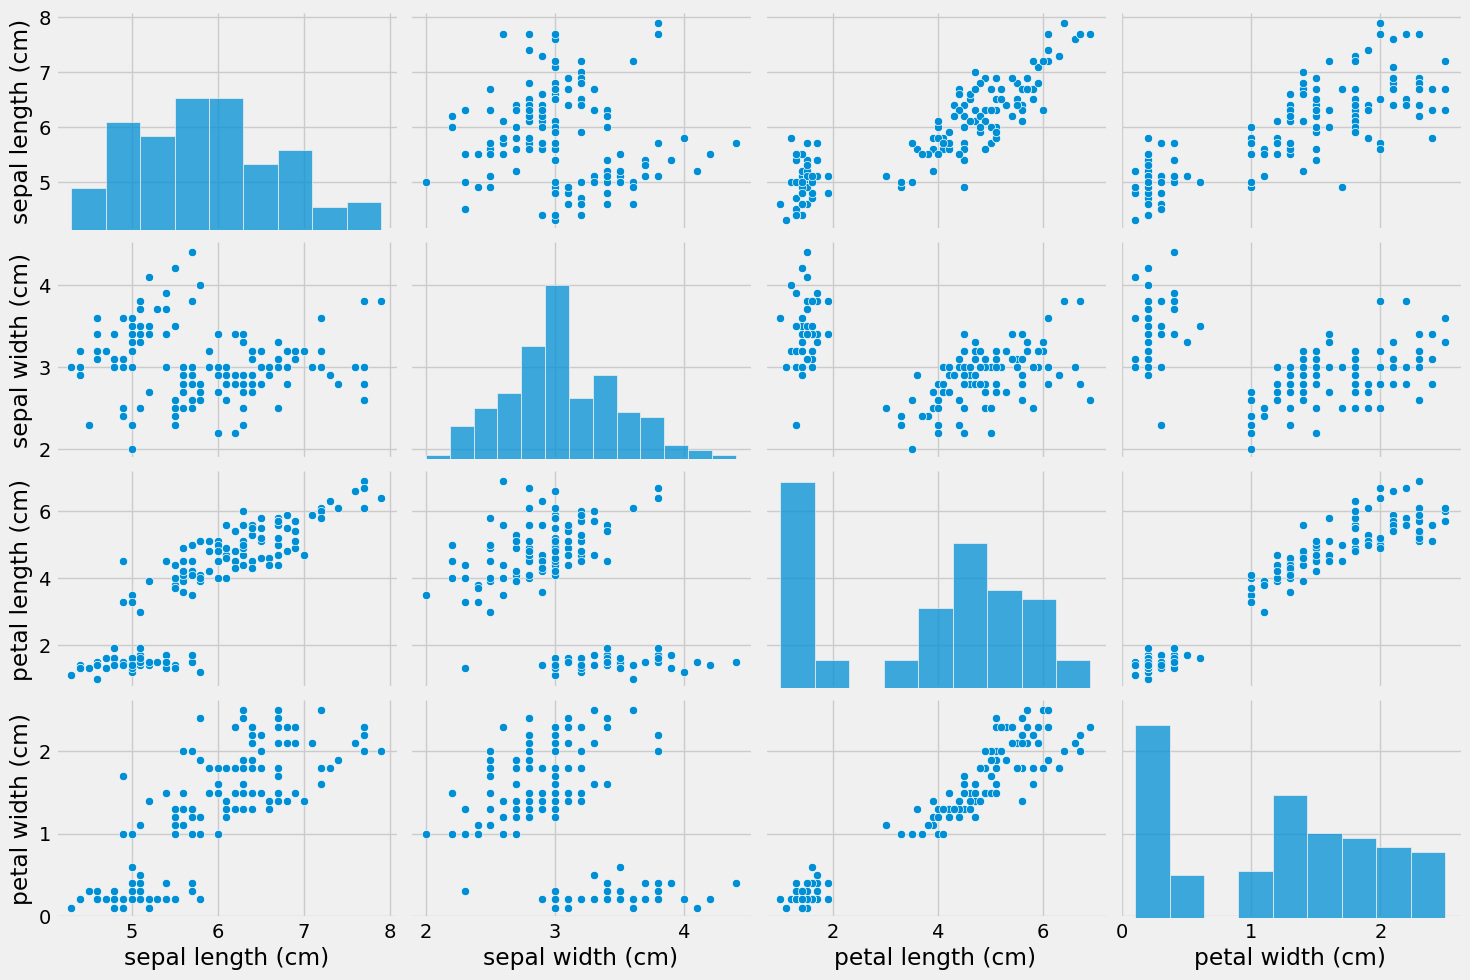

In [6]:
# initial pairplot
plt.style.use("fivethirtyeight")
sns.pairplot(df, aspect=1.5)
plt.show()

In [7]:
# some features such as petal length and petal width are showing clusters within the feature and with other features

### 1.2 PCA <a id="pca"></a>
- Use Principal component analysis to reduce dimentions. 
- Drive the optimal number of components from the variance graph.
- With 3 PCA, the explained variance is  0.95+

In [8]:
# standardize data
scaler = StandardScaler()
X = df
X_scaled = scaler.fit_transform(X)

([<matplotlib.axis.XTick at 0x212931d2eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

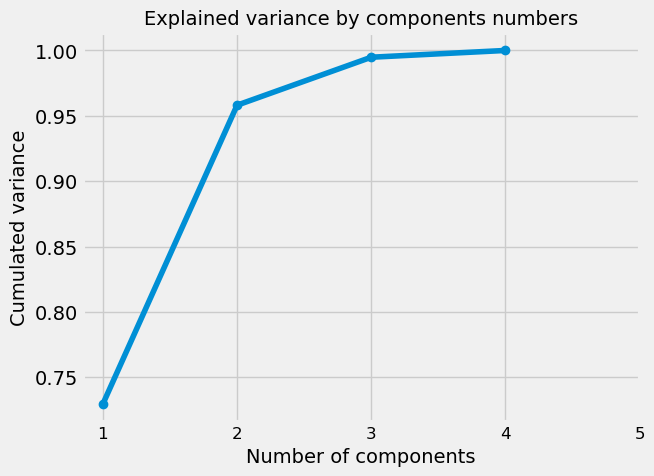

In [11]:
# PCA components test
pca = PCA()
pca.fit(X_scaled)
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o')
plt.title('Explained variance by components numbers', fontsize=14)
plt.xlabel('Number of components', fontsize=14)
plt.ylabel('Cumulated variance', fontsize=14)
plt.xticks(range(1,6), fontsize=12)
# 2 pca is good

In [12]:
# fit PCA
pca = PCA(n_components=2, random_state=42)
scores_pca = pca.fit_transform(X_scaled)

## 2. Model construction<a id="cons"></a>
### 2.1 K means <a id="ks"></a>
#### 2.1.1 Determine K <a id="dk"></a>
- Determine k using elbow method
- The max curvature happens at k = 3

optimal number of clusters: 3


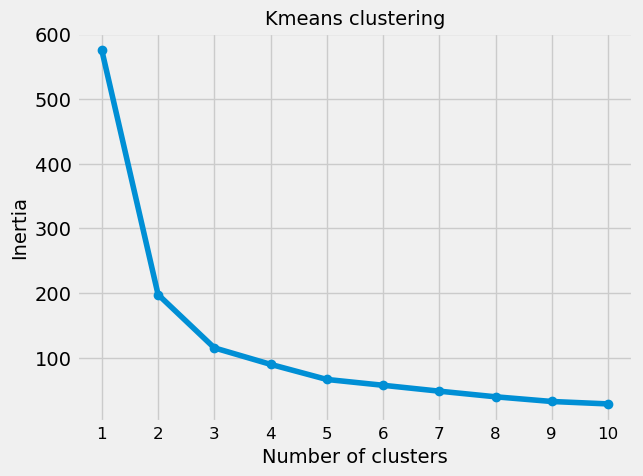

In [13]:
# Kmeans cluster numbers with elbow method
ks=range(1,11)
inertias=[]

for k in ks:
    model=KMeans(n_clusters=k,init="k-means++", random_state=42)
    model.fit(scores_pca)
    inertias.append(model.inertia_)

# identify the maximum curvature
kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
print(f'optimal number of clusters: {kl.elbow}')

# Visualize cluster numbers
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Kmeans clustering', fontsize=14)
plt.xticks(ks, fontsize=12)
plt.show()

#### 2.1.2 Dendrogram <a id="dg"></a>
- 3 clusters are reasonable

[[0.         1.16869442 0.8279384  ... 3.79174627 3.67607683 3.26455462]
 [1.16869442 0.         0.43659422 ... 3.72357137 3.84303453 3.11025362]
 [0.8279384  0.43659422 0.         ... 3.93314414 3.97446141 3.3400173 ]
 ...
 [3.79174627 3.72357137 3.93314414 ... 0.         0.75687278 0.63266145]
 [3.67607683 3.84303453 3.97446141 ... 0.75687278 0.         1.11458115]
 [3.26455462 3.11025362 3.3400173  ... 0.63266145 1.11458115 0.        ]]


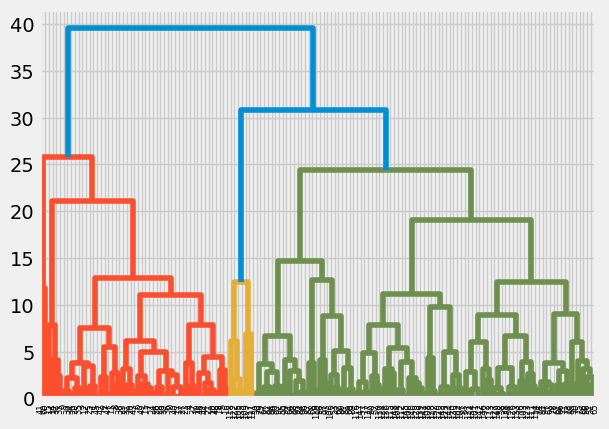

In [14]:
# Hierarchical clustering visualization
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

dist = distance_matrix(scores_pca,scores_pca)
# dist = distance_matrix(X, X)
print(dist)

Z = hierarchy.linkage(dist, 'complete') #furthest point
hd = hierarchy.dendrogram(Z,leaf_rotation=90,leaf_font_size=6)
plt.show()
# 3 groups makes sense

#### 2.1.3 Fit k means <a id="fk"></a>

In [16]:
# Kmeans pipline with PCA
preprocessor = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=42)),
    ])

ks_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, init="k-means++", random_state=42)),
    ])

ks_pipe.fit(X)

# store results in dataframe
pca_df = pd.DataFrame(
   ks_pipe["preprocessor"].transform(X),
   columns=["component_1", "component_2"],
   )

# add labels to the original dataframe
df['labels_ks']= ks_pipe["kmeans"].labels_

display(pca_df.head())

,component_1,component_2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835


### 2.2 DBSCAN model <a id="db"></a>
#### 2.2.1 Determine eps and fit the model
- The key parameter eps is tested first through KNN to determine a reasonable range and then pick the one with highest Silhouette score
- Min_samples could also be tested when time allows

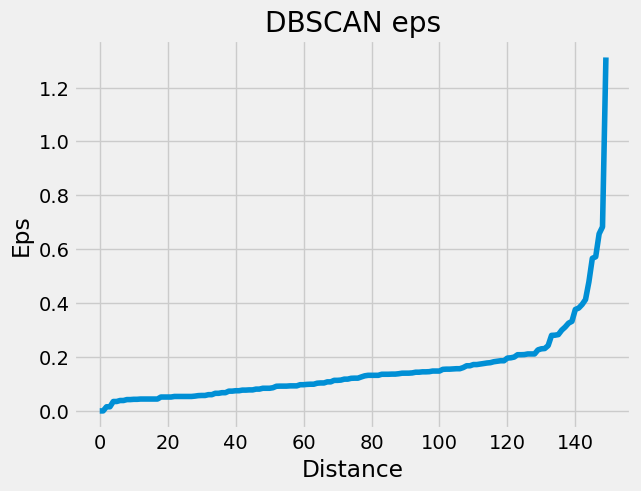

In [17]:
# use KNN to test DBSCAN eps range
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(scores_pca)
distances, indices = nbrs.kneighbors(scores_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# visualize eps in DBSCAN
plt.plot(distances)
plt.xlabel('Distance')
plt.ylabel('Eps')
plt.title('DBSCAN eps')
plt.show()
# eps ranges 0.3 - 0.8 has the max curvature

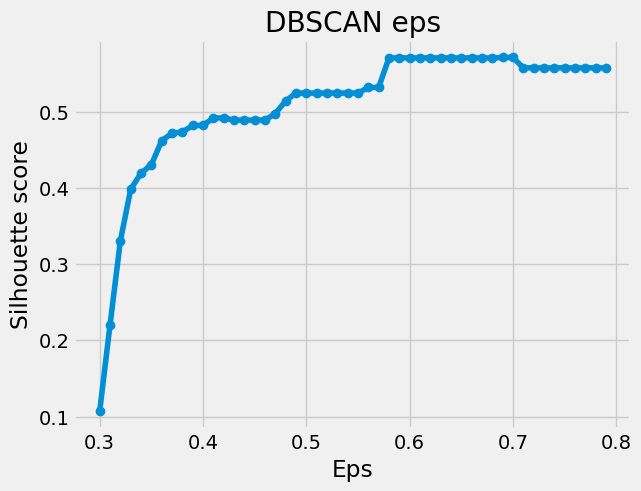

Best silhouette_score: 0.5712539122463253
Best eps: 0.6900000000000004
Number of DBSCAN clusters: 3


In [19]:
# DBSCAN model
from sklearn.cluster import DBSCAN 
eps = np.arange(0.3, 0.8, 0.01)

output = dict()

for ep in eps:
    labels = DBSCAN(eps = ep).fit(scores_pca).labels_
    score = silhouette_score(scores_pca, labels)
    output[ep] = score

# Visualize cluster numbers
plt.plot(eps, output.values(), '-o')
plt.xlabel('Eps')
plt.ylabel('Silhouette score')
plt.title('DBSCAN eps')
plt.show()

# get the best eps parameter
best_eps = max(output, key=output.get)
best_score = output[best_eps]

print(f"Best silhouette_score: {best_score}")
print(f"Best eps: {best_eps}")

# fit dbscan
db_labels = DBSCAN(eps = best_eps).fit(scores_pca).labels_

# add lable to original dataframe
df['labels_db']= db_labels

print(f"Number of DBSCAN clusters: {len(set(db_labels))}")

### 3. Results <a id="res"></a>
- Both DBSCAN and K means methods indicate 3 clusters
- DBSCAN certainly has a rather small size cluster, while K means have a more balanced size of the clusters 
- Silhouette scores though show that K means underperforms DBSCAN for this case


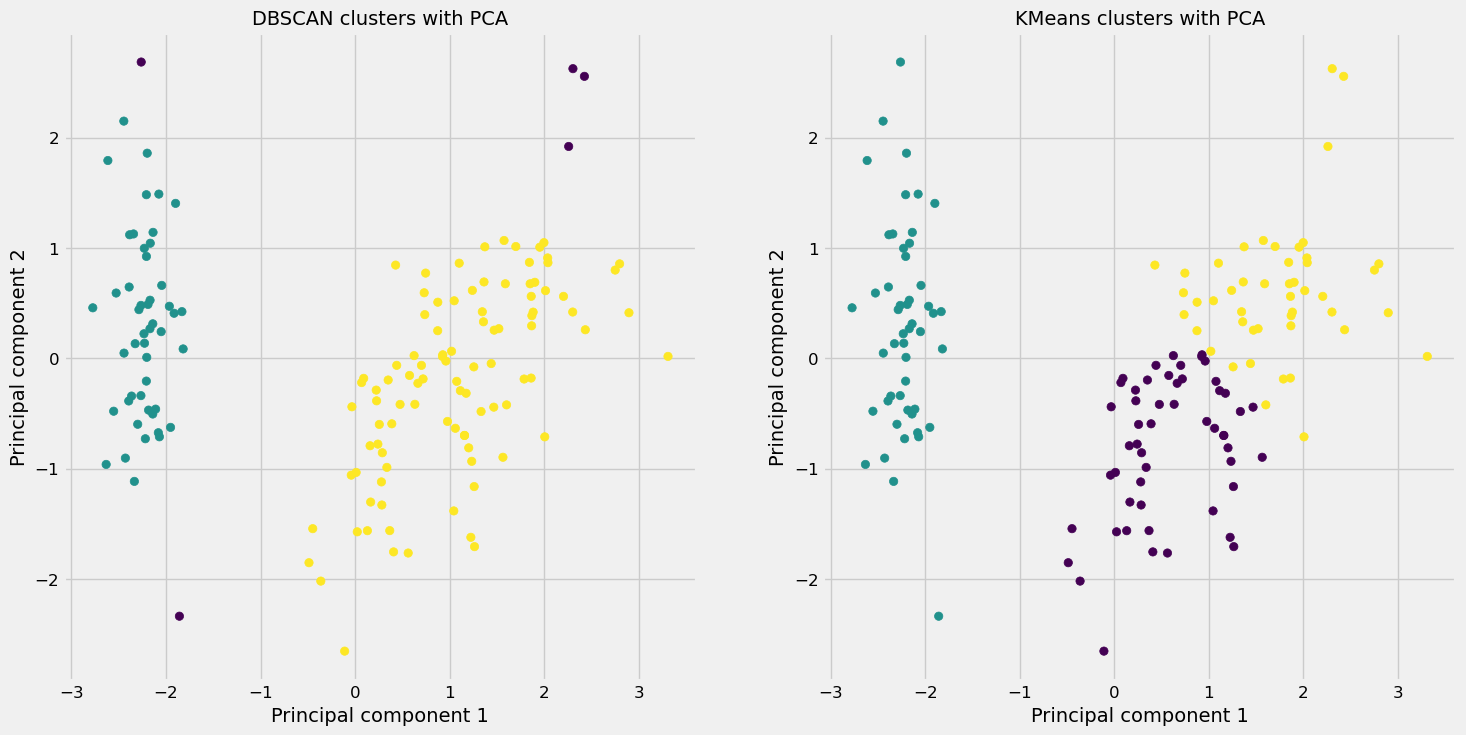

In [20]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot DBSCAN clusters with PCA in the first subplot
axs[0].scatter(pca_df["component_1"], pca_df["component_2"], c=df["labels_db"], cmap='viridis')
axs[0].set_title("DBSCAN clusters with PCA", fontsize=14)
axs[0].set_xlabel("Principal component 1", fontsize=14)
axs[0].set_ylabel("Principal component 2", fontsize=14)
axs[0].tick_params(labelsize=12)

# Plot KMeans clusters with PCA in the second subplot
axs[1].scatter(pca_df["component_1"], pca_df["component_2"], c=df["labels_ks"], cmap='viridis')
axs[1].set_title("KMeans clusters with PCA", fontsize=14)
axs[1].set_xlabel("Principal component 1", fontsize=14)
axs[1].set_ylabel("Principal component 2", fontsize=14)
axs[1].tick_params(labelsize=12)

# Display the plot
plt.show()

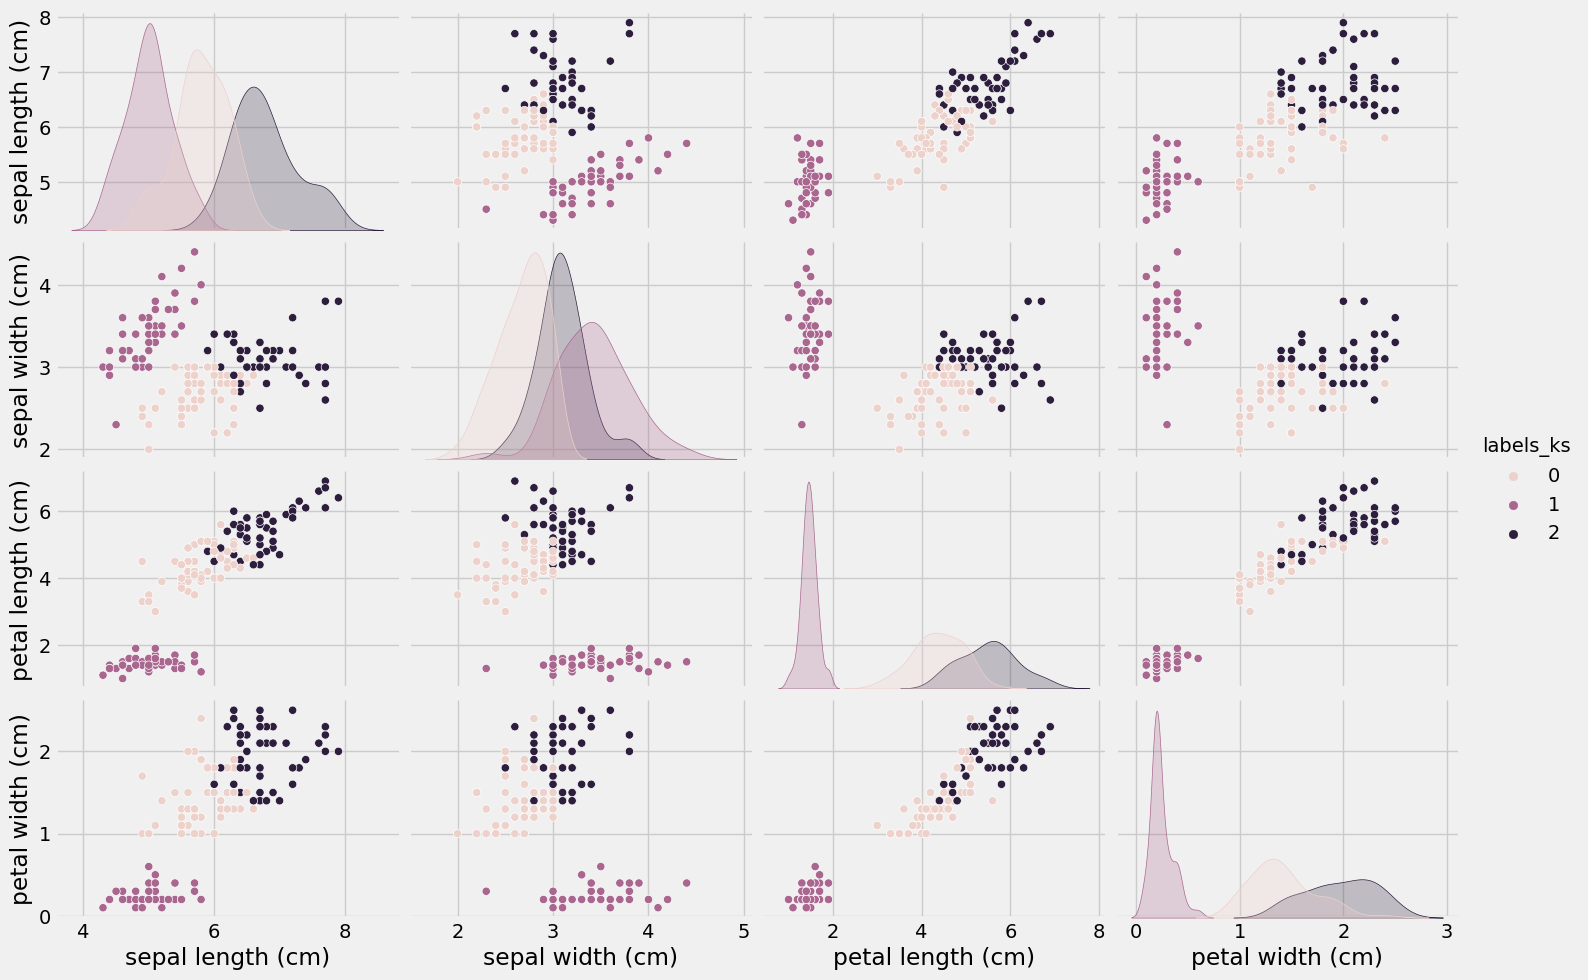

In [22]:
# pairplot with kmeans labels
sns.pairplot(df.drop('labels_db', axis=1), hue = 'labels_ks', aspect=1.5)
plt.show()

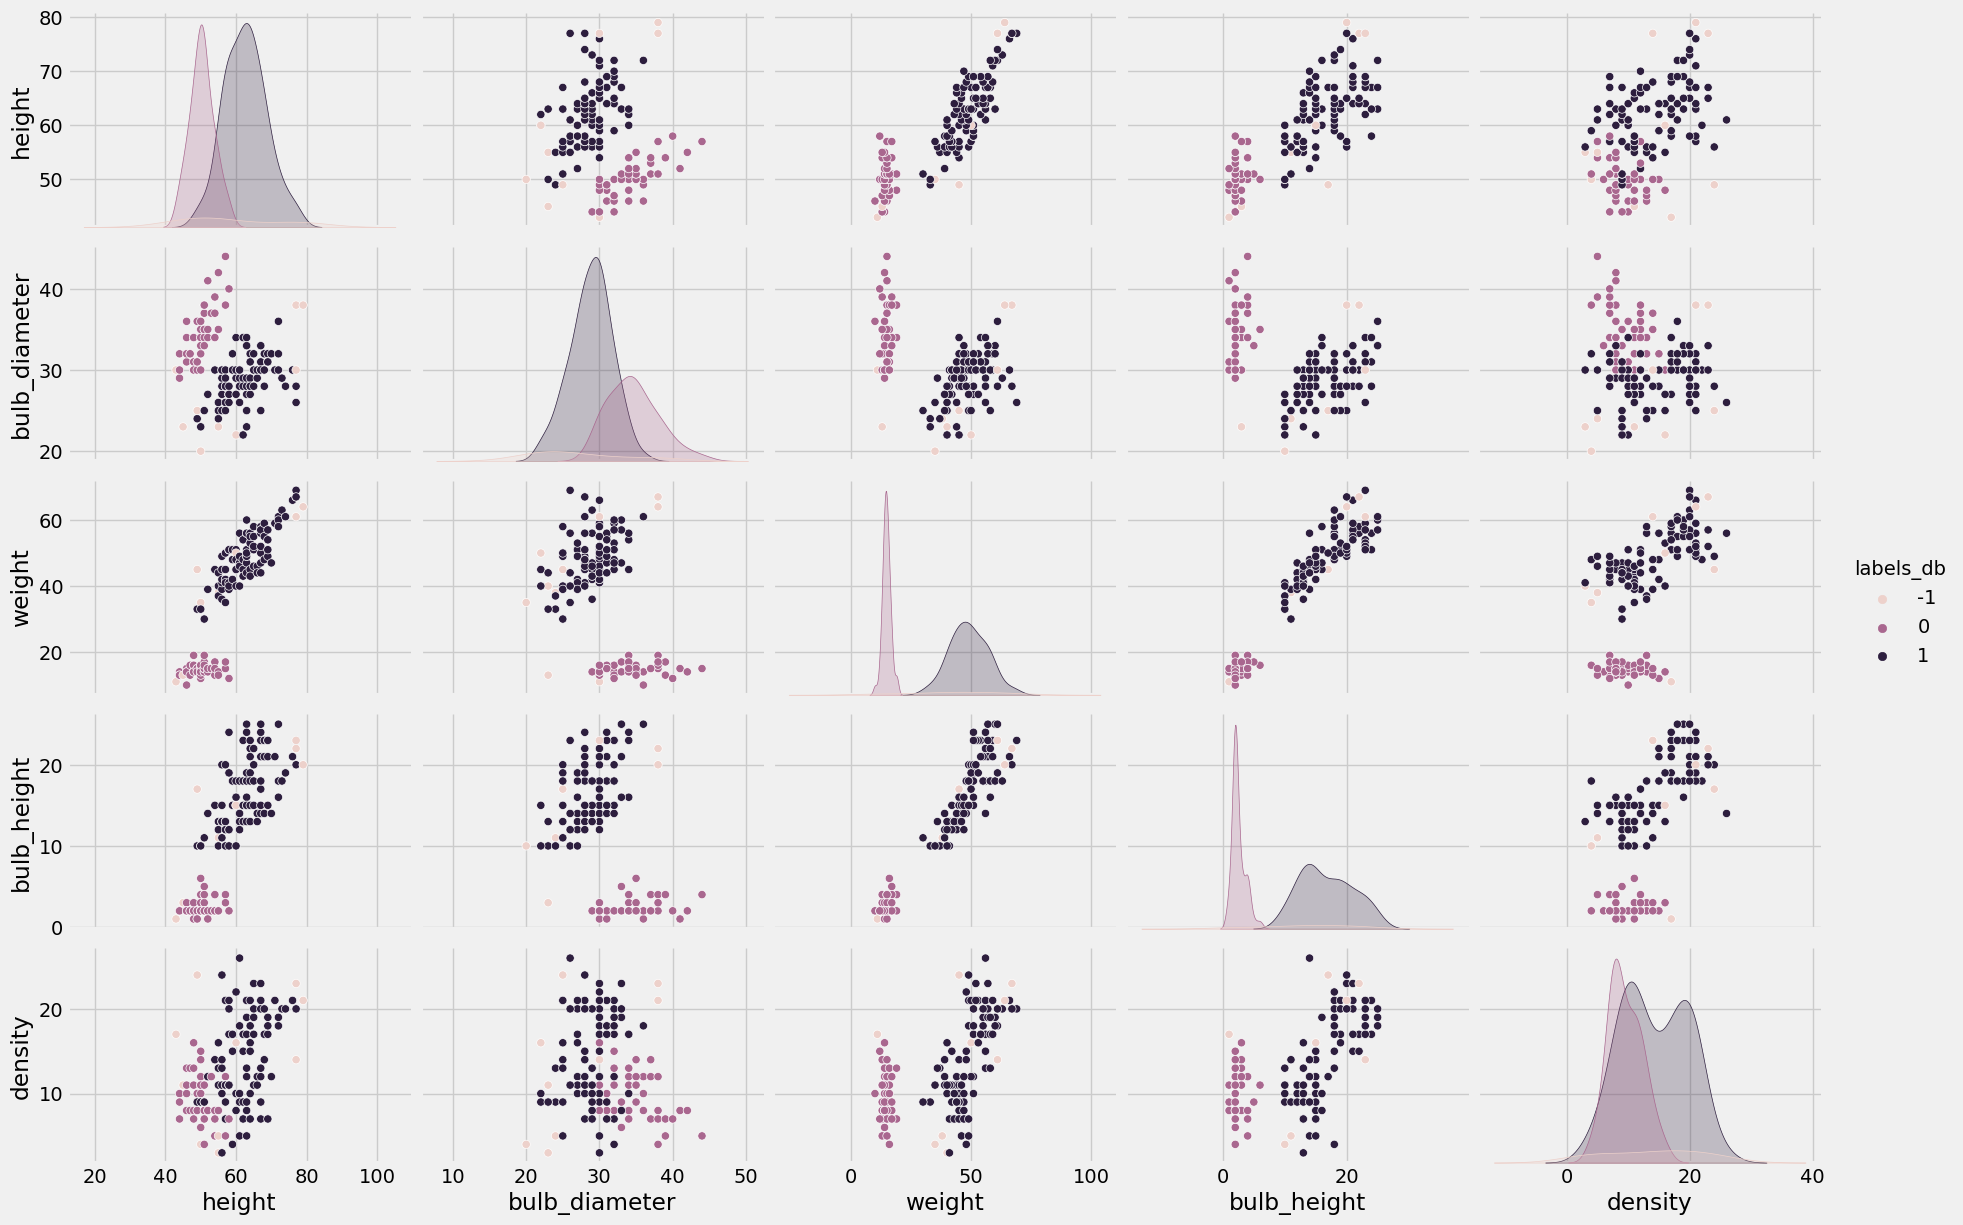

In [20]:
# pairplot with dbscan labels
sns.pairplot(df.drop('labels_ks', axis=1), hue = 'labels_db', aspect=1.5)
plt.show()

In [23]:
# since no true lables, use silhouette coefficient for evaluation
ks_silhouette = silhouette_score(
    scores_pca, df['labels_ks']).round(2)
db_silhouette = silhouette_score(
    scores_pca, df['labels_db']).round(2)
print(f'Silhouette scores for kmeans : {ks_silhouette}, for dbscan {db_silhouette}')

Silhouette scores for kmeans : 0.51, for dbscan 0.57
